# HW3-Lab1 - RNN应用 - 快递信息提取

本项目基于 [PaddlePaddle 教程](https://aistudio.baidu.com/projectdetail/1317771) 进行修改。


## Part A. 背景介绍

### A.1 快递单信息抽取任务
对于一张快递单，例如“张三 18625584663 广东省 深圳市 南山区 学府路东 百度国际大厦”，我们的目的就是识别出其中的“张三”为人名（用符号 P 表示），“18625584663”为电话名（用符号 T 表示），“广东省 深圳市 南山区 百度国际大厦”分别是 1-4 级的地址（分别用 A1~A4 表示，可以释义为省、市、区、街道）。

这是一个典型的命名实体识别（Named Entity Recognition，NER）场景，各实体类型及相应符号表示见下表：

| 抽取字段 | 简称 | 抽取结果 |
| -------- | -------- | -------- |
| 姓名     | P     | 张三     |
| 电话     | T     | 18625584663     |
| 省     | A1     | 广东省     |
| 市     | A2    | 深圳市    |
| 区 | A3 | 南山区 |
|详细地址| A4 | 百度国际大厦 |

### A.2 序列标注模型

我们可以用序列标注模型来解决快递单的信息抽取任务，下面具体介绍一下序列标注模型。


在序列标注任务中，一般会定义一个标签集合，来表示所有可能取到的预测结果。在本案例中，针对需要被抽取的“姓名、电话、省、市、区、详细地址”等实体，标签集合可以定义为：

label = {P-B, P-I, T-B, T-I, A1-B, A1-I, A2-B, A2-I, A3-B, A3-I, A4-B, A4-I, O}

每个标签的定义分别为：

| 标签 | 定义 |
| -------- | -------- |
| P-B | 姓名起始位置 |
| P-I | 姓名中间位置或结束位置 |
| T-B | 电话起始位置 |
| T-I | 电话中间位置或结束位置 |
| A1-B | 省份起始位置 |
| A1-I | 省份中间位置或结束位置 |
| A2-B | 城市起始位置 |
| A2-I | 城市中间位置或结束位置 |
| A3-B | 县区起始位置 |
| A3-I | 县区中间位置或结束位置 |
| A4-B | 详细地址起始位置 |
| A4-I | 详细地址中间位置或结束位置 |
| O | 不关注的字 |

注意每个标签的结果只有 B、I、O 三种，这种标签的定义方式叫做 BIO（Begin-Inside-Outside）体系。其中 B 表示一个标签类别的开头，比如 P-B 指的是姓名的开头；相应的，I 表示一个标签的延续。

对于句子“张三 18625584663 广东省 深圳市 南山区 百度国际大厦”，每个汉字及对应标签为：


| 张 | 三 | 1 | 8 | 6 | 2 | 5 | 5 | 8 | 4 | 6 | 6 | 3 | 广 | 东 | 省 |
|--- |---|---|---|---|---|---|---|---|---|---|---|--- |---|---|---|
| P-B | P-I | T-B | T-I | T-I | T-I | T-I | T-I | T-I | T-I | T-I | T-I | T-I | A1-B | A1-I | A1-I |
| 深 | 圳 | 市 | 南 | 山 | 区 | 百 | 度 | 国 | 际 | 大 | 厦 |
| A2-B | A2-I | A2-I | A3-B | A3-I | A3-I | A4-B | A4-I | A4-I | A4-I | A4-I | A4-I |


注意到“张“，”三”在这里表示成了“P-B” 和 “P-I”，反过来讲，得到“P-B”和“P-I”这样的序列，也可以合并成“P” 这个标签。这样重新组合后可以得到以下信息抽取结果：

| 张三 | 18625584663 | 广东省 | 深圳市 | 南山区 | 百度国际大厦 |
|:--:|:--:|:--:|:--:|:--:|:--:|
| P | T | A1 | A2 | A3 | A4 |

### A.3 信息抽取演示

下面我们通过一个例子来演示信息抽取的过程：
- 输入："云南省怒江傈僳族自治州贡山独龙族怒族自治县丙中洛镇丙中洛街头荣维维18611886869"
- 生成标签序列：['A1-B', 'A1-I', 'A1-I', 'A2-B', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A3-B', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A4-B', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'P-B', 'P-I', 'P-I', 'T-B', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I']
- 获取抽取后的结构化信息

In [1]:
def extract_information(text, tags):
    extracted_info = {"P": "", "T": "", "A1": "", "A2": "", "A3": "", "A4": ""}
    tag_to_chinese = {"P": "姓名", "T": "电话", "A1": "省份", "A2": "城市", "A3": "县区", "A4": "详细地址"}

    for char, tag in zip(text, tags):
        tag_key = tag.split("-")[0]  # 获取标签的主要部分（例如，从P-B获取P）
        if tag_key in extracted_info:
            extracted_info[tag_key] += "".join(char)
    info = {tag_to_chinese[k]: v for k, v in extracted_info.items()}
    return info


text_test = "云南省怒江傈僳族自治州贡山独龙族怒族自治县丙中洛镇丙中洛街头荣维维18611886869"
# fmt: off
tag_test = ['A1-B', 'A1-I', 'A1-I', 'A2-B', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A2-I', 'A3-B', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A3-I', 'A4-B', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'P-B', 'P-I', 'P-I', 'T-B', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I']
# fmt: on
info = extract_information(text_test, tag_test)
print(info)

{'姓名': '荣维维', '电话': '18611886869', '省份': '云南省', '城市': '怒江傈僳族自治州', '县区': '贡山独龙族怒族自治县', '详细地址': '丙中洛镇丙中洛街头'}


## Part B. 数据处理与加载

### B.1 数据准备
如果在 Kaggle notebook中，可以通过以下代码下载并解压数据集：

```bash
wget https://bj.bcebos.com/paddlenlp/paddlenlp/datasets/waybill.tar.gz
tar -zxvf waybill.tar.gz
```

解压后得到的数据目录结构如下:
```bash
├── data
│   ├── train.txt   # 训练集
│   ├── test.txt    # 测试集
│   ├── dev.txt     # 验证集
│   ├── word.dic    # 文本词典
│   └── tag.dic     # label词典
```


### B.2 创建词汇表

我们首先需要构建一个Vocab类，将每个字映射到一个唯一的 ID。

如果`word.dic`中没有这个字，则将其映射为 out-of-vocabulary `"OOV"`。
如果`tag.dic`中没有这个标签，则将其映射为 `"O"`。

In [2]:
def load_dict(dict_path):
    vocab = {}
    i = 0
    with open(dict_path, "r", encoding="utf-8") as fin:
        for line in fin:
            key = line.strip("\n")
            vocab[key] = i
            i += 1
    return vocab


class Vocab:
    def __init__(self, vocab_path, oov_token="OOV"):
        self.word2id = load_dict(vocab_path)
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.vocab_size = len(self.word2id)
        # out-of-vocabulary token
        self.oov_token = oov_token

    def word_to_id(self, word):
        # TODO: 将 word 转换为其对应的 ID, 如果 word 不在词典中, 则返回 oov_token 对应的ID
        return self.word2id.get(word, self.word2id[self.oov_token])

    def id_to_word(self, id):
        return self.id2word[id]

    def __len__(self):
        return len(self.word2id)

    def __call__(self, words):
        return [self.word_to_id(word) for word in words]

以下是使用示例和测试：

In [3]:
word_vocab = Vocab("data/word.dic", "OOV")
label_vocab = Vocab("data/tag.dic", "O")

print(word_vocab("黑龙江省"))
assert word_vocab("黑龙江省") == [521, 100, 178, 1817]

print(word_vocab(["黑", "龙", "江", "省"]))
assert word_vocab(["黑", "龙", "江", "省"]) == [521, 100, 178, 1817]

print(word_vocab(["OOV", "黑龙江"]))
assert word_vocab(["OOV", "黑龙江"]) == [20939, 20939]

[521, 100, 178, 1817]
[521, 100, 178, 1817]
[20939, 20939]


In [4]:
print(label_vocab(["P-B", "T-B"]))
assert label_vocab(["P-B", "T-B"]) == [0, 2]

print(label_vocab(["O", "TB"]))
assert label_vocab(["O", "TB"]) == [12, 12]

[0, 2]
[12, 12]


### B.3 创建NER数据集

我们这里用到 `train.txt`、`test.txt` 两个文件，分别创建训练集和测试集。

txt文件中的第一行是 `text_a label`，中间的空格是制表符。
从第二行开始，后面的每行数据都是由两列组成，以制表符分隔，第一列是 utf-8 编码的中文文本，第二列是对应序列标注的结果，中间每个字符用 `\002` 分割。

我们需要将这些文本数据转换为pytorch格式的tensor数据，以便后续训练使用，这一部分将在`NerDataset`类中实现。

In [5]:
import torch
from torch.utils.data import Dataset


class NerDataset(Dataset):
    def __init__(self, data_path, word_vocab: Vocab, label_vocab: Vocab):
        self.word_vocab = word_vocab
        self.label_vocab = label_vocab
        self.word_ids = []
        self.label_ids = []
        self.read_data(data_path)

    def read_data(self, path):
        with open(path, "r", encoding="utf-8") as fp:
            next(fp)  # Skip the header line
            for line in fp.readlines():
                words, labels = line.strip("\n").split("\t")
                words = words.split("\002")
                labels = labels.split("\002")

                # TODO: 使用 word_vocab 将 words 转换为 word_id, 类型为 torch.long
                word_id = torch.tensor(self.word_vocab(words), dtype=torch.long)
                # TODO: 使用 label_vocab 将 labels 转换为 label_id, 类型为 torch.long
                label_id = torch.tensor(self.label_vocab(labels), dtype=torch.long)

                self.word_ids.append(word_id)
                self.label_ids.append(label_id)

    def __len__(self):
        return len(self.word_ids)

    def __getitem__(self, item):
        return self.word_ids[item], self.label_ids[item], len(self.word_ids[item])

In [6]:
eval_dataset = NerDataset("data/dev.txt", word_vocab, label_vocab)

word1, label1, seqlen1 = eval_dataset[1]
print(word1)
print(label1)
print(seqlen1)
assert (word1[0:10] == torch.tensor([12, 22, 27, 17, 24, 22, 22, 23, 12, 22], dtype=torch.long)).all()
assert (label1[0:10] == torch.tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=torch.long)).all()
assert seqlen1 == 32

word2, label2, seqlen2 = eval_dataset[-1]
print(word2)
print(label2)
print(seqlen2)
assert (word2[0:10] == torch.tensor([12, 21, 24, 12, 12, 30, 21, 24, 27, 12], dtype=torch.long)).all()
assert (label2[0:10] == torch.tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=torch.long)).all()
assert seqlen2 == 14

tensor([  12,   22,   27,   17,   24,   22,   22,   23,   12,   22,   21, 1566,
         403,  443,  521,  100,  178, 1817,  732,  718,  404, 1503,  889,  137,
        1628,  304, 1067,  183,  396,  234,  267, 1125])
tensor([ 2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  1,  1,  4,  5,  5,  5,
         6,  7,  7,  7,  8,  9,  9, 10, 11, 11, 11, 11, 11, 11])
32
tensor([  12,   21,   24,   12,   12,   30,   21,   24,   27,   12,   30, 1573,
        8248,  631])
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1])
14


### B.4 创建DataLoader

观察以上数据，我们可以发现一个问题：每个样本的长度是不一样的，这时候我们就需要对数据进行padding操作，使得每个batch中的样本长度一致。

一种简单的方法是将所有样本都padding或截断到同样的长度，但是如果序列太长，会导致padding的部分过多，从而浪费计算资源。如果序列太短，又会导致部分信息的丢失。

因此，一个更好的方法是动态padding，即每个batch中的样本长度不同，但是在一个batch内，将每个样本padding到该batch中的最大长度。

这个操作可以通过`DataLoader`的`collate_fn`参数实现，对于word序列，我们填充 `word_vocab(["OOV"])`，对于label序列，我们填充 `label_vocab(["O"])`。

In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader


def collate_fn(batch):
    words, labels, seqlens = zip(*batch)
    words = nn.utils.rnn.pad_sequence(words, batch_first=True, padding_value=20939)  # word_vocab(["OOV"])
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=12)  # label_vocab(["O"])
    seqlens = torch.tensor(seqlens, dtype=torch.long)
    return words, labels, seqlens


eval_dataloader = DataLoader(eval_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)
for words, labels, seqlens in eval_dataloader:
    print(words)
    print(seqlens)
    break

tensor([[ 1194,    73,   231,   102,   211,  1817,   560,   328,  3715,  1256,
           478,   484,   737,   211,    68,  1161,    98,  1075,   348,   332,
           183,    22,    30,  1162,    12,    23,    21,    12,    22,    22,
            23,    24,    12,    24,    22, 20939, 20939, 20939, 20939, 20939],
        [   12,    22,    27,    17,    24,    22,    22,    23,    12,    22,
            21,  1566,   403,   443,   521,   100,   178,  1817,   732,   718,
           404,  1503,   889,   137,  1628,   304,  1067,   183,   396,   234,
           267,  1125, 20939, 20939, 20939, 20939, 20939, 20939, 20939, 20939],
        [  585,   211,  1817,   188,   311,  1503,   607,  3237,  1628,   349,
          1578,   183,    22,    12,  1162,   765,   465,   168,  1455,   267,
          1125,    30,   600,    17,    12,   691,  2140,    83,   360,    12,
            22,    24,     9,    12,    17,    24,    28,    21,    22,    23]])
tensor([35, 32, 40])


## Part C. 训练

### C.1 构建 BiGRU 模型

我们使用BiGRU作为基础模型，BiGRU的结构如下：

- Embedding层：将输入的字符id映射为向量表示
- BiGRU层：将Embedding层的输出作为BiGRU的输入，得到每个字符的输出表示
- Linear层：将BiGRU的输出映射到标签空间

In [8]:
class BiGRU(nn.Module):
    def __init__(self, embedding_dim=300, hidden_size=300, word_vocab_len=20940, label_vocab_len=13):
        super(BiGRU, self).__init__()
        self.word_embed = nn.Embedding(word_vocab_len, embedding_dim)
        # TODO: 实现双向GRU层
        self.bigru = nn.GRU(embedding_dim, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        # TODO: 实现线性层
        self.fc = nn.Linear(hidden_size * 2, label_vocab_len)

    def forward(self, x):
        embs = self.word_embed(x)
        output, _ = self.bigru(embs)
        output = self.fc(output)
        return output


model_test = BiGRU()
x_test = torch.randint(0, 20940, (3, 32))
output = model_test(x_test)
print(output.shape)
assert output.shape == torch.Size([3, 32, 13])

torch.Size([3, 32, 13])


### C.2 模型训练

In [9]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, train_iter, loss_fn, optimizer):
    net.train()
    device = next(net.parameters()).device
    metrics = Accumulator(4)
    for X, y, lens in train_iter:
        X, y, lens = X.to(device), y.to(device), lens.to(device)
        y_hat = net(X)
        # TODO: 计算损失
        loss = loss_fn(y_hat.view(-1, y_hat.shape[-1]), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num = y.shape[0] * y.shape[1]
        metrics.add(loss * num, accuracy(y_hat, y) * num, num)
        train_loss = metrics[0] / metrics[2]
        train_acc = metrics[1] / metrics[2]
    return train_loss, train_acc


@torch.no_grad()
def eval_model(net, test_iter, loss_fn):
    net.eval()
    device = next(net.parameters()).device
    metrics = Accumulator(3)
    for X, y, lens in test_iter:
        X, y, lens = X.to(device), y.to(device), lens.to(device)
        # TODO: 计算损失
        y_hat = net(X)
        loss = loss_fn(y_hat.view(-1, y_hat.shape[-1]), y.view(-1))

        num = y.shape[0] * y.shape[1]
        metrics.add(loss * num, accuracy(y_hat, y) * num, num)
    test_loss = metrics[0] / metrics[2]
    test_acc = metrics[1] / metrics[2]
    return test_loss, test_acc


def accuracy(y_hat, y_true):
    y_pred = y_hat.argmax(dim=-1)
    return (y_pred == y_true).float().mean().item()

In [10]:
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiGRU(300, 300, 20940, 13)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_dataset = NerDataset("data/train.txt", word_vocab, label_vocab)
test_dataset = NerDataset("data/dev.txt", word_vocab, label_vocab)
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_iter = DataLoader(test_dataset, batch_size=256, collate_fn=collate_fn)

train_ls, test_ls, train_acc_ls, test_acc_ls = [], [], [], []
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch(model, train_iter, loss_fn, optimizer)
    test_loss, test_acc = eval_model(model, test_iter, loss_fn)
    print(
        f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f} - Train Acc: {train_acc:.6f} - Test Acc: {test_acc:.6f}"
    )
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)
# save model
# torch.save(model.state_dict(), "model.pth")

Epoch 1/50 - Train Loss: 0.685887 - Test Loss: 0.176076 - Train Acc: 0.792104 - Test Acc: 0.954250
Epoch 2/50 - Train Loss: 0.115852 - Test Loss: 0.045996 - Train Acc: 0.971027 - Test Acc: 0.988750
Epoch 3/50 - Train Loss: 0.036425 - Test Loss: 0.018384 - Train Acc: 0.990788 - Test Acc: 0.994750
Epoch 4/50 - Train Loss: 0.014254 - Test Loss: 0.010863 - Train Acc: 0.996705 - Test Acc: 0.996750
Epoch 5/50 - Train Loss: 0.006567 - Test Loss: 0.009304 - Train Acc: 0.998746 - Test Acc: 0.997500
Epoch 6/50 - Train Loss: 0.004843 - Test Loss: 0.008938 - Train Acc: 0.999194 - Test Acc: 0.997083
Epoch 7/50 - Train Loss: 0.002618 - Test Loss: 0.007623 - Train Acc: 0.999660 - Test Acc: 0.997583
Epoch 8/50 - Train Loss: 0.001403 - Test Loss: 0.007644 - Train Acc: 0.999867 - Test Acc: 0.997667
Epoch 9/50 - Train Loss: 0.001027 - Test Loss: 0.008135 - Train Acc: 0.999927 - Test Acc: 0.997333
Epoch 10/50 - Train Loss: 0.000781 - Test Loss: 0.007990 - Train Acc: 0.999963 - Test Acc: 0.997333
Epoch 11/

### C.3 模型评估

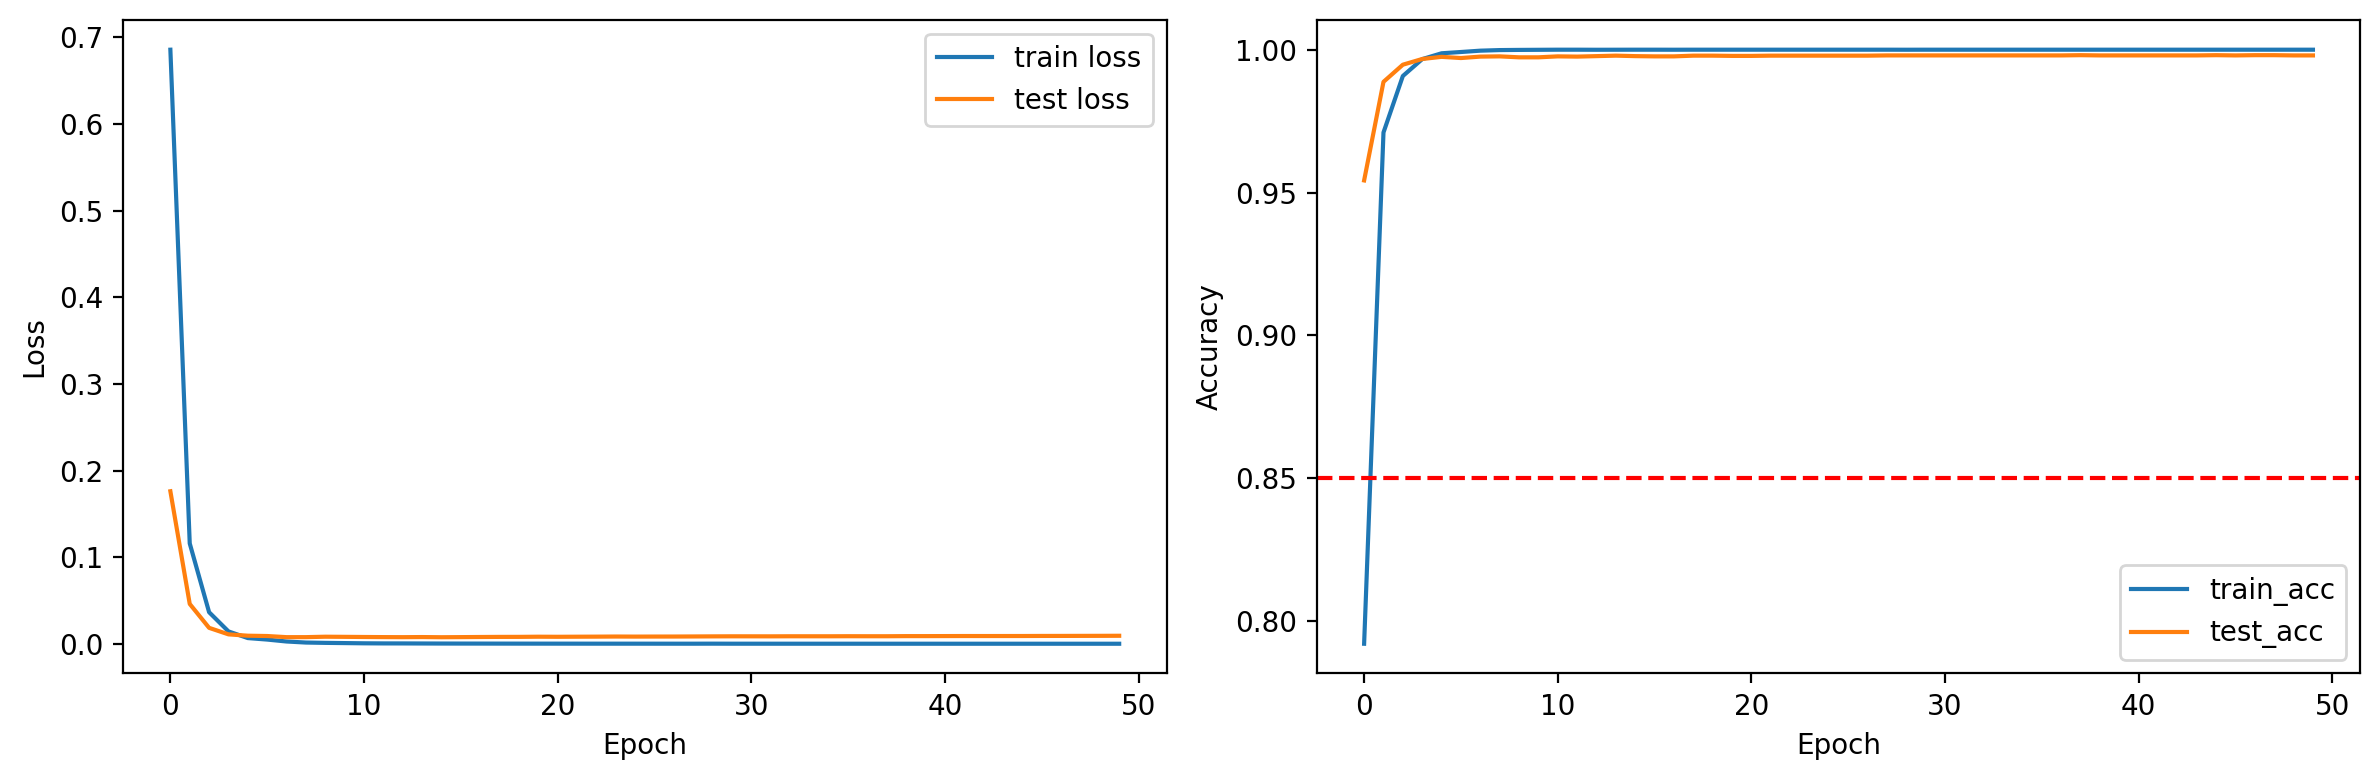

Best test accuaracy:  0.9980832934379578


In [11]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 绘制第一个子图
axs[0].plot(train_ls, label="train loss")
axs[0].plot(test_ls, label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# 绘制第二个子图
axs[1].plot(train_acc_ls, label="train_acc")
axs[1].plot(test_acc_ls, label="test_acc")
axs[1].axhline(y=0.85, color='r', linestyle='--')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()
print("Best test accuaracy: ", max(test_acc_ls))

## C.4 预测

In [12]:
text = "广东省梅州市大埔县茶阳镇胜利路13601328173张铱"
text_ids = torch.tensor(word_vocab(text), dtype=torch.long).to(device)
output = model(text_ids.unsqueeze(0))
y_pred = output.argmax(dim=-1)
tags_pred = [label_vocab.id2word[int(x)] for x in y_pred[0]]
print(tags_pred)

['A1-B', 'A1-I', 'A1-I', 'A2-B', 'A2-I', 'A2-I', 'A3-B', 'A3-I', 'A3-I', 'A4-B', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'A4-I', 'T-B', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'T-I', 'P-B', 'P-I']


In [13]:
info = extract_information(text, tags_pred)
print(info)

{'姓名': '张铱', '电话': '13601328173', '省份': '广东省', '城市': '梅州市', '县区': '大埔县', '详细地址': '茶阳镇胜利路'}


## Part D. 拓展阅读

### D.1 条件随机场CRF(Conditional Random Fields)

在上面的结果中，我们可以看到输出的标签序列存在一些问题，这是因为网络没有充分挖掘到序列的上下文关系。

例如，电话号码通常是连续的，如果在一段文字中突然出现了一个数字，那么这个数字大概率是门牌号而不是电话号码。

为了解决这个问题，我们可以使用条件随机场（CRF）来对上下文关系进行建模，这里我们直接使用训练好的CRF层，如果想详细了解CRF怎么在模型中使用，可以参考 [Chinese-Medical-Entity-Recognition](https://github.com/XavierWww/Chinese-Medical-Entity-Recognition/blob/master/models.py)

In [14]:
class CRF(nn.Module):
    """Adopted from https://github.com/kmkurn/pytorch-crf/blob/master/torchcrf/__init__.py

    Args:
        num_tags: Number of tags.

    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.
    """

    def __init__(self, num_tags: int) -> None:
        super().__init__()
        self.num_tags = num_tags
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

    def viterbi_decode(self, emissions: torch.FloatTensor):
        # Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
        mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8).bool()
        emissions = emissions.transpose(0, 1)
        mask = mask.transpose(0, 1)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()
        seq_length, batch_size = mask.shape
        # Start transition and first emission
        score = self.start_transitions + emissions[0]
        history = []

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            broadcast_score = score.unsqueeze(2)
            broadcast_emission = emissions[i].unsqueeze(1)
            next_score = broadcast_score + self.transitions + broadcast_emission
            # Find the maximum score over all possible current tag
            next_score, indices = next_score.max(dim=1)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)
        # End transition score
        score += self.end_transitions
        # Now, compute the best path for each sample
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []
        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]
            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[: seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())
            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list


crf = CRF(13).to(device)
crf.load_state_dict(torch.load("crf.pth"))

<All keys matched successfully>

接下来，我们测试经过CRF层优化后的效果：

In [15]:
y_crf = crf.viterbi_decode(output)
tags_pred = [label_vocab.id2word[int(x)] for x in y_crf[0]]
info = extract_information(text, tags_pred)
print(info)

{'姓名': '张铱', '电话': '13601328173', '省份': '广东省', '城市': '梅州市', '县区': '大埔县', '详细地址': '茶阳镇胜利路'}


In [16]:
text = "北京市昌平区高教园南三街9号北京航空航天大学18600009172刘伟"
text_ids = torch.tensor(word_vocab(text), dtype=torch.long).to(device)
output = model(text_ids.unsqueeze(0))
y_crf = crf.viterbi_decode(output)
tags_pred = [label_vocab.id2word[int(x)] for x in y_crf[0]]
info = extract_information(text, tags_pred)
print(info)

{'姓名': '刘伟', '电话': '18600009172', '省份': '', '城市': '北京市', '县区': '昌平区', '详细地址': '高教园南三街9号北京航空航天大学'}


### D.2 预训练词向量优化

我们可以用大型的预训练模型来代替Embedding层，这样能进一步优化模型的文本理解效果，这里不再演示，感兴趣的同学可以自行尝试bert-base-chinese等中文模型。